# Description synthétique du projet et de ses objectifs

# Installation

In [3]:
%%capture
!pip install datasets
!pip install gensim
!pip install catboost


# Importation

In [22]:
from datasets import load_dataset
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
import re
from multiprocessing import Pool
from gensim.models.word2vec import Word2Vec

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from gensim.models import KeyedVectors
from sklearn.model_selection import cross_val_score
from catboost import CatBoostClassifier


from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.exceptions import NotFittedError
from itertools import product

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Dense, LSTM, GlobalMaxPooling1D, Conv1D, Flatten, Bidirectional
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Chargement des données

In [5]:
current_path = '/content/drive/MyDrive/Bihar-project/Allocine-project/'
result_path = f'{current_path}Allocine-project/model/'
model_path = f'{current_path}Allocine-project/data/'

In [6]:
dataset = load_dataset("allocine")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/160000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/20000 [00:00<?, ? examples/s]

In [7]:
train_df = dataset['train'].to_pandas()
validation_df = dataset['validation'].to_pandas()
test_df = dataset['test'].to_pandas()

In [8]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 800)

In [9]:
train_df_copy = train_df.copy()
validation_df_copy = validation_df.copy()
test_df_copy = test_df.copy()

In [10]:
train_df_copy.head()

,review,label
0,"Si vous cherchez du cinéma abrutissant à tous les étages,n'ayant aucune peur du cliché en castagnettes et moralement douteux,""From Paris with love"" est fait pour vous.Toutes les productions Besson,via sa filière EuropaCorp ont de quoi faire naître la moquerie.Paris y est encore une fois montrée comme une capitale exotique,mais attention si l'on se dirige vers la banlieue,on y trouve tout plein d'intégristes musulmans prêts à faire sauter le caisson d'une ambassadrice américaine.Nauséeux.Alors on se dit qu'on va au moins pouvoir apprécier la déconnade d'un classique buddy-movie avec le jeune agent aux dents longues obligé de faire équipe avec un vieux lou complètement timbré.Mais d'un côté,on a un Jonathan Rhys-meyers fayot au possible,et de l'autre un John Travolta en total délire narc...",0
1,"Trash, re-trash et re-re-trash...! Une horreur sans nom. Imaginez-vous les 20 premières minutes de Orange Mécanique dilatées sur plus de 70 minutes de bande VHS pourrave et revisitées par Korine à la sauce années 2000 : les dandys-punk de Kubrick ont laissé place à des papys lubriques déguisés en sacs-poubelles forniquant les troncs d'arbres, le dispositif esthétique se résume à du filmage-réalité enfilant des scènes de destruction, de soumission, de pornographie ou encore de maltraitance ( youtube, youtube et re-youtube...) et la bande-son se limite à des ricanements malades, des rengaines obsédantes et limitées, de la logorrhée sans queue ni tête surgissant par bribes poétiques ( hummm....) et des explosions de pétard et de débris. Sur le plan émotionnel c'est une réussite complète p...",0
2,"Et si, dans les 5 premières minutes du film, la pathétique maquette de train fendant la neige en gros plan laissait bien augurer du reste ? Si cet artifice trop visible illustrait toute la lourdeur des 100 et quelques minutes de bobine, tous ces atermoiements, tout ce sentimentalisme à deux balles… ? Et une fois ce « train » arrivé en gare, qui peut croire honnêtement au coup de foudre du Comte Vronsky pour Anna ?! Or tout le film est axé sur ce moment… Seule le petit délire suicido-ferroviaire final d’Anna est à la hauteur. P… de train !",0
3,"Mon dieu ! Quelle métaphore filée ! Je suis abasourdi ! Mais réellement, ici on a une métaphore filée de l'acceptation que sa mère puisse à nouveau avoir une sexualité avec quelqu'un d'autre que son papounet chéri ! Freud est aux anges et moi aussi ! Sauf qu'en fait c'est nul... Ce n'est pas un Disney Channel Original Movie très intéressant, faut dire qu'il est franchement vieux, il date de l'an 2000, d'un autre millénaire ! Les gens qui ont fait ce film n'ont pas connu le 11 septembre ! Vous vous rendez compte ? Toute cette candeur était encore possible ! époque bénie des dieux ! Outre la blague, on retrouve déjà tous les poncifs du genre, la meilleure amie noire, l'ennemie qui devient l'amie... la belle soeur qui au début énerve et puis finalement on s'y attache... oh que c'est migno...",0
4,"Premier film de la saga Kozure Okami, ""Le Sabre de la vengeance"" est un très bon film qui mêle drame et action, et qui, en 40 ans, n'a pas pris une ride.",1


In [11]:
X_train = train_df_copy['review']
X_test = test_df_copy['review']
X_val = validation_df_copy ['review']

y_train = train_df_copy['label']
y_test = test_df_copy['label']
y_val = validation_df_copy ['label']

# Analyse exploratoire des données

# Prétraitement des données

In [12]:
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Sentences tokenizer
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
stopwords_en = stopwords.words("french")


In [13]:
def text_to_words(text, stopwords=None):
    # supprimer des liens hypertextes
    text = re.sub(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", " ", text)
    # supprimer des balises html
    text = BeautifulSoup(text, "lxml").get_text()
    # remplacer les caractères autres que des lettres par des expaces
    text = re.sub("[^a-zA-Z]", " ", text)
    # mettre en minuscules et convertir en liste de mots
    words = text.lower().split()
    # keep only non empty strings
    words = [w for w in words if w]
    if stopwords is not None:
        # supprimer les mots vides de la langue anglaise
        words = [w for w in words if not w in stopwords]
    return(words)

# option 1: tokenize reviews by sentences + text_to_words for each sentence
# option 2: text_to_words for each review
def review_to_sentences(review, tokenizer=tokenizer, stopwords=None):
    # token = phrase
    raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) != 0:
            sentences.append(text_to_words(raw_sentence, stopwords))
    return sentences

In [14]:
def review_to_sentences_custom(review):
    return review_to_sentences(review, stopwords=stopwords_en)

with Pool(4) as p:
    X_train_sentences = list(tqdm(p.imap(review_to_sentences_custom, X_train), total=len(X_train)))
    X_val_sentences = list(tqdm(p.imap(review_to_sentences_custom, X_val), total=len(X_val)))
    X_test_sentences = list(tqdm(p.imap(review_to_sentences_custom, X_test), total=len(X_test)))

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/160000 [00:00<?, ?it/s]

<ipython-input-13-b34bb46b0405>:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "lxml").get_text()
<ipython-input-13-b34bb46b0405>:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "lxml").get_text()
<ipython-input-13-b34bb46b0405>:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "lxml").get_text()
<ipython-input-13-b34bb46b0405>:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "lxml").get_text()
<ipython-input-13-b34bb46b0405>:5: Marku

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

In [15]:
X_train_words = [[word for sentence in doc for word in sentence] for doc in X_train_sentences]
X_test_words = [[word for sentence in doc for word in sentence] for doc in X_test_sentences]
X_test_val = [[word for sentence in doc for word in sentence] for doc in X_val_sentences]

len(X_train_words), len(X_test_val), len(X_test_words)

(160000, 20000, 20000)

# Modélisation et évaluation des perfo rmances des modèles

## EmbeddingVectorizer

In [ ]:
mode_cine_fr = KeyedVectors.load_word2vec_format("/content/drive/MyDrive/Bihar-project/Allocine-project/model/frWac_no_postag_no_phrase_700_skip_cut50.bin", binary=True, unicode_errors="ignore")


In [ ]:
model_cine_dict = dict(zip(mode_cine_fr.index_to_key, mode_cine_fr.vectors))

In [ ]:
mode_cine_fr.most_similar("salut")

In [ ]:
class MeanEmbeddingVectorizer(TransformerMixin):
    def __init__(self, word2vec_model):
        self.word2vec_model = word2vec_model
        self.dim = word2vec_model.vector_size

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec_model[word] for word in words if word in self.word2vec_model] or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

class TfidfEmbeddingVectorizer(object):

    def __init__(self, word2vec_dict):
        self.word2vec_dict = word2vec_dict
        self.word2weight = None
        self.dim = len(list(word2vec_dict.values())[0])

    def fit(self, X, y=None):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        self.word2weight = defaultdict(
            lambda: max(tfidf.idf_),
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        if self.word2weight is None:
            msg = "This TfidfEmbeddingVectorizer instance is not fitted yet. Call 'fit' with appropriate arguments before using this transformer."
            raise NotFittedError(msg)

        return np.array([
                np.mean([self.word2vec_dict[w] * self.word2weight[w]
                         for w in words if w in self.word2vec_dict] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

## Fitting pipeline

### MeanEmbeddingVectorizer

In [ ]:
rfc_w2v = Pipeline([
    ("vectorizer", MeanEmbeddingVectorizer(mode_cine_fr)),
    ("classifier", RandomForestClassifier())])

In [ ]:
catb_w2v = Pipeline([
    ("vectorizer", MeanEmbeddingVectorizer(mode_cine_fr)),
    ("classifier", CatBoostClassifier(verbose=0))  # Set verbose=0 to avoid verbose output
])

In [ ]:
%%time
rfc_w2v.fit(X_train_words, y_train)

CPU times: user 10min 16s, sys: 1.44 s, total: 10min 17s
Wall time: 10min 36s


Pipeline(steps=[('vectorizer',
                 <__main__.MeanEmbeddingVectorizer object at 0x7e983ff38550>),
                ('classifier', RandomForestClassifier())])

In [ ]:
%%time
catb_w2v.fit(X_train_words, y_train)

CPU times: user 16min 52s, sys: 4.26 s, total: 16min 57s
Wall time: 10min 26s


Pipeline(steps=[('vectorizer',
                 <__main__.MeanEmbeddingVectorizer object at 0x7e983ff39900>),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x7e983ff385b0>)])

#### Validation MeanEmbeddingVectorizer

##### Ramdomforest

              precision    recall  f1-score   support

           0       0.78      0.78      0.78     10204
           1       0.77      0.77      0.77      9796

    accuracy                           0.78     20000
   macro avg       0.78      0.78      0.78     20000
weighted avg       0.78      0.78      0.78     20000



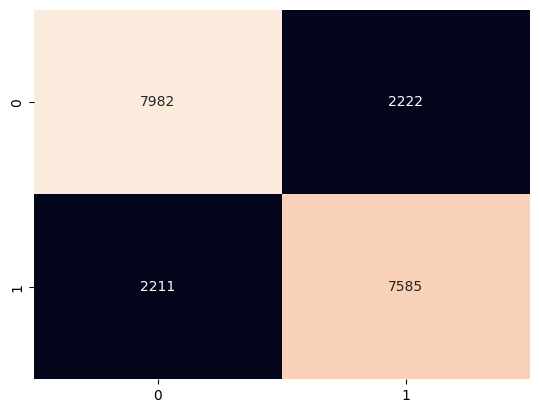

In [ ]:
y_pred_val = rfc_w2v.predict(X_test_val)
print(classification_report(y_val, y_pred_val))
sns.heatmap(data=confusion_matrix(y_val, y_pred_val), annot=True, fmt="d", cbar=False, xticklabels=rfc_w2v.classes_, yticklabels=rfc_w2v.classes_);

##### Catboost

              precision    recall  f1-score   support

           0       0.85      0.84      0.85     10204
           1       0.84      0.85      0.84      9796

    accuracy                           0.85     20000
   macro avg       0.85      0.85      0.85     20000
weighted avg       0.85      0.85      0.85     20000



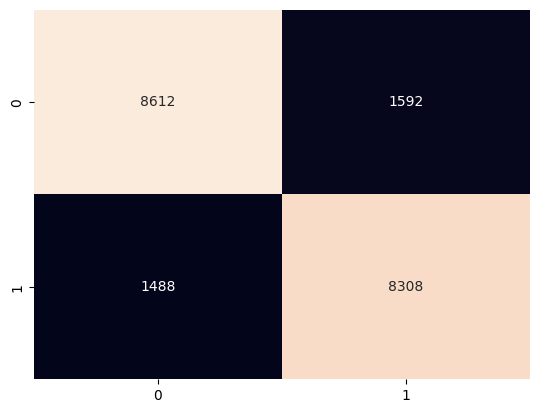

In [ ]:
y_pred_val = catb_w2v.predict(X_test_val)
print(classification_report(y_val, y_pred_val))
sns.heatmap(data=confusion_matrix(y_val, y_pred_val), annot=True, fmt="d", cbar=False, xticklabels=catb_w2v.classes_, yticklabels=catb_w2v.classes_);

#### Test MeanEmbeddingVectorizer

##### Ramdomforest

              precision    recall  f1-score   support

           0       0.51      0.85      0.64     10204
           1       0.50      0.16      0.24      9796

    accuracy                           0.51     20000
   macro avg       0.51      0.50      0.44     20000
weighted avg       0.51      0.51      0.44     20000



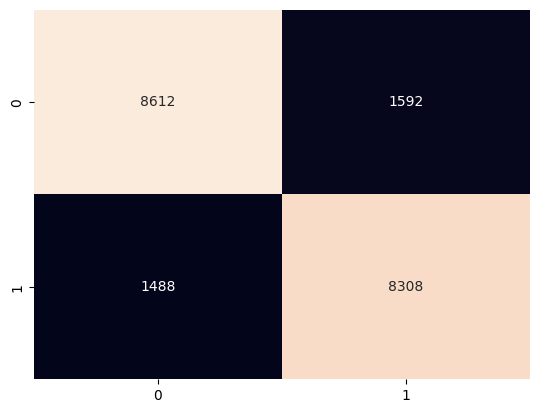

In [ ]:
y_pred = rfc_w2v.predict(X_test)
print(classification_report(y_val, y_pred))
sns.heatmap(data=confusion_matrix(y_val, y_pred_val), annot=True, fmt="d", cbar=False, xticklabels=rfc_w2v.classes_, yticklabels=rfc_w2v.classes_);

##### Catboost

              precision    recall  f1-score   support

           0       0.86      0.85      0.85     10408
           1       0.84      0.85      0.84      9592

    accuracy                           0.85     20000
   macro avg       0.85      0.85      0.85     20000
weighted avg       0.85      0.85      0.85     20000



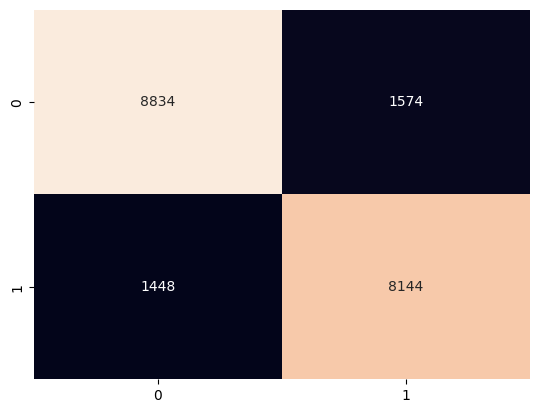

In [ ]:
y_pred = catb_w2v.predict(X_test_words)
print(classification_report(y_test, y_pred))
sns.heatmap(data=confusion_matrix(y_test, y_pred), annot=True, fmt="d", cbar=False, xticklabels=catb_w2v.classes_, yticklabels=catb_w2v.classes_);

### TfidfEmbeddingVectorizer

In [ ]:
tfidf_vec = TfidfEmbeddingVectorizer(model_cine_dict)


In [ ]:
rfc_w2v_tfidf = Pipeline([
    ("vectorizer", TfidfEmbeddingVectorizer(model_cine_dict)),
    ("classifier", RandomForestClassifier())])

In [ ]:
catb_w2v__tfidf = Pipeline([
    ("vectorizer", TfidfEmbeddingVectorizer(model_cine_dict)),
    ("classifier", RandomForestClassifier(verbose=0))  # Set verbose=0 to avoid verbose output
])

In [ ]:
%%time
rfc_w2v_tfidf.fit(X_train_words, y_train)

CPU times: user 12min 4s, sys: 1.47 s, total: 12min 5s
Wall time: 12min 21s


Pipeline(steps=[('vectorizer',
                 <__main__.TfidfEmbeddingVectorizer object at 0x7e97f0d77040>),
                ('classifier', RandomForestClassifier())])

In [ ]:
catb_w2v__tfidf.fit(X_train_words, y_train)

#### Validation TfidfEmbeddingVectorizer

##### Ramdomforest

              precision    recall  f1-score   support

           0       0.76      0.75      0.76     10204
           1       0.75      0.76      0.75      9796

    accuracy                           0.75     20000
   macro avg       0.75      0.75      0.75     20000
weighted avg       0.75      0.75      0.75     20000



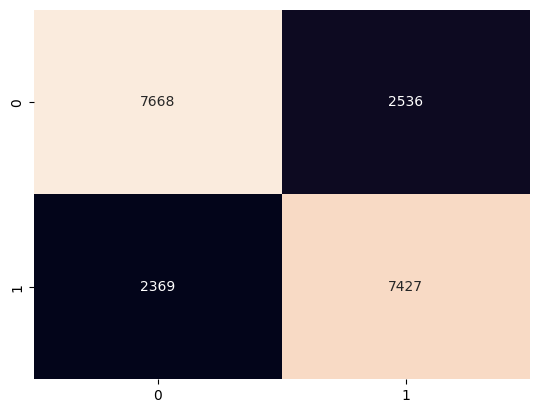

In [ ]:
y_pred_val = rfc_w2v_tfidf.predict(X_test_val)
print(classification_report(y_val, y_pred_val))
sns.heatmap(data=confusion_matrix(y_val, y_pred_val), annot=True, fmt="d", cbar=False, xticklabels=rfc_w2v.classes_, yticklabels=rfc_w2v.classes_);

##### Catboost

In [ ]:
y_pred_val_tf = catb_w2v__tfidf.predict(X_test_val)
print(classification_report(y_val, y_pred_val_tf))
sns.heatmap(data=confusion_matrix(y_val, y_pred_val_tf), annot=True, fmt="d", cbar=False, xticklabels=catb_w2v__tfidf.classes_, yticklabels=catb_w2v__tfidf.classes_);

#### Test TfidfEmbeddingVectorizer

##### Ramdomforest

In [ ]:
y_pred_test_tf = rfc_w2v_tfidf.predict(X_test_words)
print(classification_report(y_test, y_pred_test_tf))
sns.heatmap(data=confusion_matrix(y_test, y_pred_test_tf), annot=True, fmt="d", cbar=False, xticklabels=rfc_w2v.classes_, yticklabels=rfc_w2v.classes_);

##### Catboost

In [ ]:
y_pred_test_tf = catb_w2v__tfidf.predict(X_test_val)
print(classification_report(y_test, y_pred_test_tf))
sns.heatmap(data=confusion_matrix(y_test, y_pred_test_tf), annot=True, fmt="d", cbar=False, xticklabels=catb_w2v__tfidf.classes_, yticklabels=catb_w2v__tfidf.classes_);

## LSTM


### Preprocessing

In [16]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train_words)


X_train_dl = word_tokenizer.texts_to_sequences(X_train_words)
X_dev_dl = word_tokenizer.texts_to_sequences(X_test_val)
X_test_dl = word_tokenizer.texts_to_sequences(X_test_words)
vocab_length = len(word_tokenizer.word_index) + 1


In [17]:
maxlen = 200
X_train = pad_sequences(X_train_dl, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_dev_dl, padding='post', maxlen=maxlen)
X_dev  = pad_sequences(X_dev_dl , padding='post', maxlen=maxlen)

### Baseline model

In [18]:
class LSTMModel(Sequential):
    def __init__(self, vocab_length, maxlen, optimizer='adam', dropout=0.0):
        super().__init__()
        self.add(Embedding(input_dim=vocab_length, output_dim=100, input_length=maxlen))
        self.add(LSTM(units=128, return_sequences=False))
        if dropout > 0.0:
            self.add(Dropout(dropout))
        self.add(Dense(1, activation='sigmoid'))
        self.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])



In [ ]:
lstm_model = LSTMModel(vocab_length, maxlen, optimizer='adam', dropout=0.2)

print(lstm_model.summary())


In [ ]:
lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=24, epochs=6, verbose=1, validation_split=0.2)

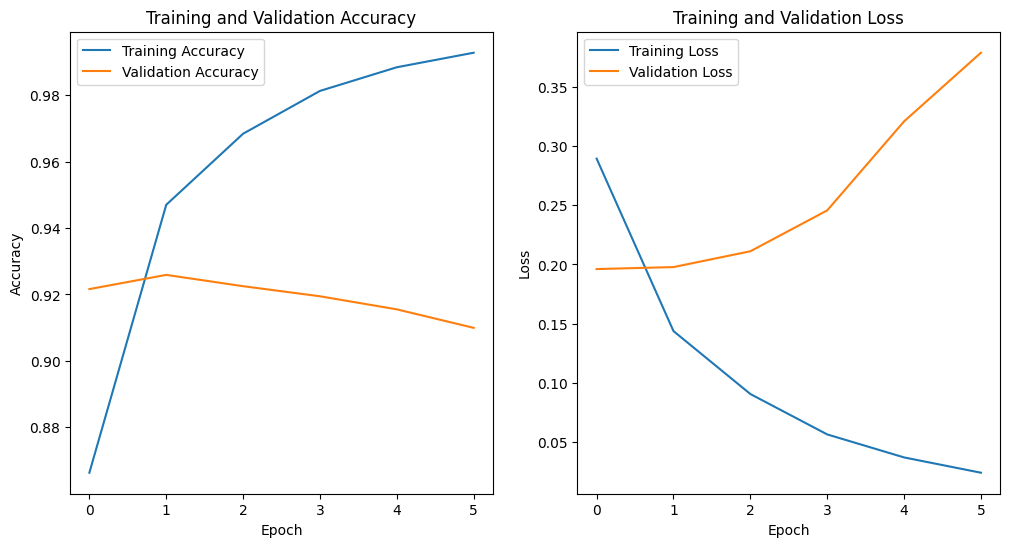

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(lstm_model_history.history['acc'], label='Training Accuracy')
plt.plot(lstm_model_history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(lstm_model_history.history['loss'], label='Training Loss')
plt.plot(lstm_model_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

## Tunning LSTM

In [ ]:


#optimizer_list = ['adam', 'rmsprop', 'adagrad']  # Optimizer names as strings

optimizer_list = [tf.keras.optimizers.legacy.Adam(), tf.keras.optimizers.legacy.RMSprop(), tf.keras.optimizers.legacy.Adagrad()]

dropout_rates = [0.0, 0.2, 0.4]
batch_sizes = [32, 64, 128]
results_list = []
best_model = None
best_accuracy = 0.0
best_model_history = None

for optimizer_name, dropout_rate, batch_size in product(optimizer_list, dropout_rates, batch_sizes):

    lstm_model = LSTMModel(vocab_length, maxlen, optimizer=optimizer_name, dropout=dropout_rate)  # Pass optimizer name as string
    checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = lstm_model.fit(X_train, y_train, epochs=10, batch_size=batch_size, validation_data=(X_val, y_val), verbose=0, callbacks=[early_stopping])
    loss, accuracy = lstm_model.evaluate(X_val, y_val)
    result = {
        'Optimizer': optimizer_name,
        'Dropout Rate': dropout_rate,
        'Batch Size': batch_size,
        'Validation Accuracy': accuracy
    }
    results_list.append(result)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = lstm_model
        best_model_history = history.history


results_df = pd.DataFrame(results_list)

results_df.to_csv(f'{result_path}experiment_results.csv', index=False)
best_model.save(f'{model_path}best_model_final.h5')
print(results_df)
